# Exercise 2: Convolution GAN for MNIST digits

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [9]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


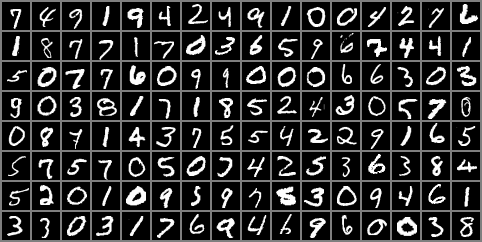

In [10]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [11]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
# import torchsummary

# # Create some generator and discriminator
# netG = Generator().to(device)
# netD = Discriminator().to(device)

# torchsummary.summary(netG, input_size=(nz,1,1))
# torchsummary.summary(netD, input_size=(1,28,28))


## Display Samples of the Generator

In [12]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

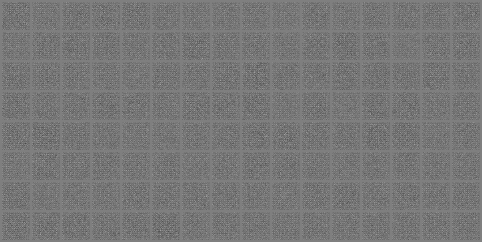

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [15]:
def lipconstant(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n

    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    Di = D(interp).view(-1)
    gradout = torch.ones(Di.size(), device=device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)) + 1e-12)
    return torch.mean(gradients_norm)

def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n

    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = alpha * y + (1 - alpha) * x
    interp.requires_grad_()

    Di = D(interp).view(-1)
    gradout = torch.ones(Di.size(), device=device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)) + 1e-12)
    return ((gradients_norm - 1) ** 2).mean()

y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D,x,y))
print(gradient_penalty(D,x,y))

tensor(1.8197, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6702, device='cuda:0', grad_fn=<MeanBackward0>)


In [17]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 5
log_every = 100
gpw = 20

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init);
D.apply(weights_init);

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size,nz,1,1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        optimD.zero_grad()
        D_real = D(real).view(-1)
        D_fake = D(faked).view(-1)
        gp = gradient_penalty(D, real, faked)
        Dloss = -torch.mean(D_real) + torch.mean(D_fake) + gpw * gp
        Dloss.backward()
        optimD.step()
        optimG.zero_grad()
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        D_fake = D(fake).view(-1)
        Gloss = -torch.mean(D_fake)
        Gloss.backward()
        optimG.step()
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(),lipconstant(D,real,faked)))
            show(G,zviz)

print('Total learning time = ',time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


Output hidden; open in https://colab.research.google.com to view.

In [18]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

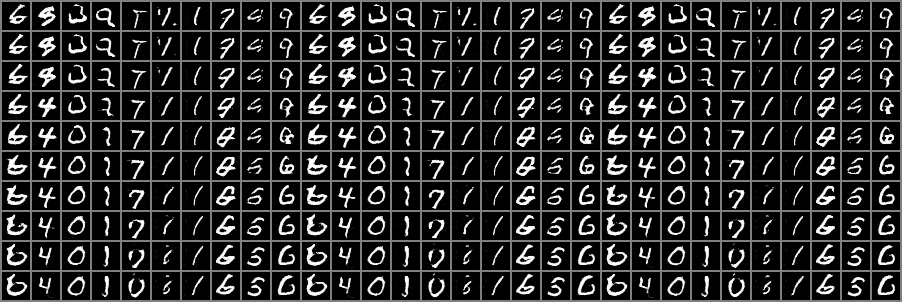

In [19]:
# You may load a trained generator from a file
# G = Generator().to(device)
# G.load_state_dict(torch.load('wgan_epoch100.pt'))
# G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in range(nk):
    alpha = k / (nk - 1)
    z_alpha = (1 - alpha) * z0 + alpha * z1
    genimages[k*minib:(k+1)*minib] = G(z_alpha).detach().cpu()

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

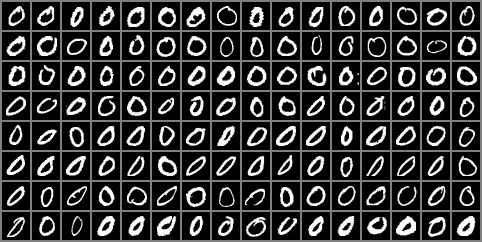

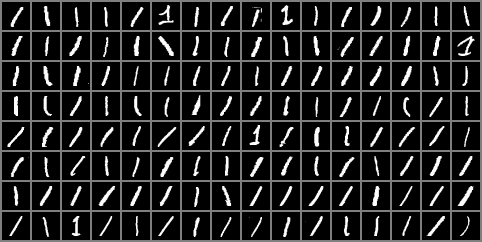

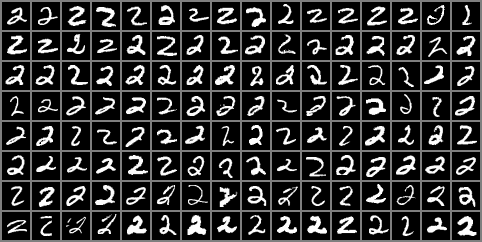

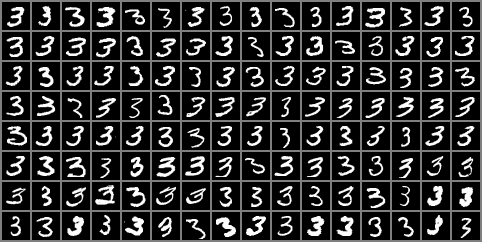

In [20]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

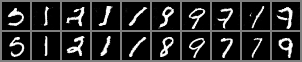

In [24]:
import torch.nn.functional as F

def find_nearest_neighbors(generated_images, dataset_images):
    distances = F.pairwise_distance(generated_images.view(generated_images.size(0), -1),
                                    dataset_images.view(dataset_images.size(0), -1).unsqueeze(1))
    nearest_neighbors = torch.argmin(distances, dim=0)
    return nearest_neighbors

num_samples = 10
z = torch.randn(num_samples, nz, 1, 1, device=device)
generated_samples = G(z).detach().cpu()

nearest_neighbors_indices = find_nearest_neighbors(generated_samples, y)
nearest_neighbors = y[nearest_neighbors_indices]

combined_images = torch.cat([generated_samples, nearest_neighbors], dim=0)
imshow(torchvision.utils.make_grid(combined_images, nrow=num_samples))

